# Supervised Vector-Quantized Variational AutoEncoder (S-VQ-VAE)

## Example applicatoin on MNIST data

Some codes are referred to the following resources:

https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb

https://github.com/nadavbh12/VQ-VAE/blob/master/vq_vae/auto_encoder.py

https://github.com/ritheshkumar95/pytorch-vqvae/blob/master/modules.py

In [5]:
from __future__ import division
import sys
import math
import time
import operator
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data as Tdata
import torchvision.datasets as datasets
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.stats import gaussian_kde
import seaborn as sns

##  Define S-VQ-VAE

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### VQ for S-VQ-VAE

In [8]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, divergence_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost
        self._divergence_cost = divergence_cost
    
    def forward(self, inputs, label):
        # Calculate distances
        distances = (torch.sum(inputs**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(inputs, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.reshape(label,(label.shape[0], 1))
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)
        
        close_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        close_encodings = torch.zeros(close_indices.shape[0], self._num_embeddings).to(device)
        close_encodings.scatter_(1, close_indices, 1)
        
        indicator = 1 - (encoding_indices == close_indices).int()
        indicator = indicator.float()
        
        # Quantize
        quantized = torch.matmul(encodings, self._embedding.weight)
        close_quantized = torch.matmul(close_encodings, self._embedding.weight)
        
        # Loss
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        x_latent_loss = torch.mean(indicator * ((close_quantized - inputs.detach())**2))
        d_latent_loss = torch.mean(indicator * ((close_quantized.detach() - inputs)**2))
        loss = q_latent_loss + self._commitment_cost * e_latent_loss - x_latent_loss - self._divergence_cost * d_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return loss, quantized, perplexity, encodings

### VQ for standard VQ-VAE

In [9]:
class VectorQuantizer_normal(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, divergence_cost):
        super(VectorQuantizer_normal, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost
    
    def forward(self, inputs, label):
        # Calculate distances
        distances = (torch.sum(inputs**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(inputs, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize
        quantized = torch.matmul(encodings, self._embedding.weight)
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return loss, quantized, perplexity, encodings

### S-VQ-VAE model

In [10]:
class S_VQ_VAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, divergence_cost, normal=0):
        super(S_VQ_VAE, self).__init__()
        self.fc1 = nn.Tanh()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 20, 5, 2), # 20 x (28-(5-1))/2 x (28-(5-1))/2 = 20 x 12 x 12
            nn.ReLU(True),
            nn.Conv2d(20, 50, 5, 1), # 50 x (12-(5-1))/1 x (12-(5-1))/1 = 50 x 8 x 8
            nn.ReLU(True))
        
        
        if normal > 0:
            self._vq = VectorQuantizer_normal(num_embeddings, embedding_dim, 
                                              commitment_cost, divergence_cost)
        else:
            self._vq = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost, divergence_cost)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(50, 20, 3, 3), # 20 x (8-1)*3+1+2 x (8-1)*3+1+2 = 20 x 24 x 24
            nn.ReLU(True),
            nn.ConvTranspose2d(20, 1, 5, 1), # 1 x 24+4 x 24+4 = 1 x 28 x 28
            nn.Tanh())

    def forward(self, x, label):
        z = self.encoder(x)
        z = z.view(-1, 8*8*50)
        z = self.fc1(z)
        loss, quantized, perplexity, encodings = self._vq(z, label)
        quantized = quantized.view(-1,50,8,8)
        x_recon = self.decoder(quantized)        
        return loss, x_recon, perplexity, encodings, quantized

## Train on MNSIT data

### Load MNIST data

In [21]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img_transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])
])
trainDataset = datasets.MNIST('./data', download=True, train=True, transform=img_transform)
testDataset = datasets.MNIST('./data', download=True, train=False, transform=img_transform)
print(len(trainDataset))
print(len(testDataset))

60000
10000


### Start training

In [22]:
num_epochs = 25
batch_size = 256
learning_rate = 1e-3
embedding_dim = 50*8*8
num_embeddings = 10
commitment_cost = 0.25
divergence_cost = 0.1
normal = 0

model_S_VQ_VAE = S_VQ_VAE(num_embeddings, embedding_dim, commitment_cost, divergence_cost, normal).to(device)
optimizer  = torch.optim.Adam(model_S_VQ_VAE.parameters(), lr=learning_rate, amsgrad=True)
criterion = nn.MSELoss()

In [23]:
trainDataLoader = Tdata.DataLoader(dataset = trainDataset, batch_size = batch_size, shuffle = True)
testDataLoader = Tdata.DataLoader(dataset = testDataset)
print(len(trainDataLoader.dataset), len(testDataLoader.dataset))

60000 10000


In [24]:
train_recon_error = []
train_perplexity = []
startTime = time.time()
for epoch in range(num_epochs):
    model_S_VQ_VAE.train()
    epoch_recon_error = []
    epoch_perplexity = []
    for step, data in enumerate(trainDataLoader):
        optimizer.zero_grad()
        inputData, label = data
        inputData = inputData.to(device)
        label = label.to(device)
        vq_loss, data_recon, perplexity, _, encoded = model_S_VQ_VAE(inputData, label)
        recon_error = criterion(data_recon, inputData)
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
    
        epoch_recon_error.append(recon_error.item())
        epoch_perplexity.append(perplexity.item())
    recon_error = np.mean(epoch_recon_error)
    mean_perplexity = np.mean(epoch_perplexity)
    train_recon_error.append(recon_error)
    train_perplexity.append(mean_perplexity)
    print('Epoch %d' % epoch)
    print('recon_error: %.3f' % recon_error)
    print('perplexity: %.3f' % mean_perplexity)
    timeSpent = round(time.time() - startTime, 2)
    print('Time spent: ' + str(timeSpent) + 's.')
    print('')
timeSpent = round(time.time() - startTime, 2)
print('Done.\nTime spent: ' + str(timeSpent) + 's.')

Epoch 0
recon_error: 0.410
perplexity: 9.814
Time spent: 36.72s.

Epoch 1
recon_error: 0.247
perplexity: 9.803
Time spent: 74.26s.

Epoch 2
recon_error: 0.236
perplexity: 9.811
Time spent: 111.37s.

Epoch 3
recon_error: 0.233
perplexity: 9.804
Time spent: 148.07s.

Epoch 4
recon_error: 0.230
perplexity: 9.812
Time spent: 184.54s.

Epoch 5
recon_error: 0.228
perplexity: 9.804
Time spent: 223.07s.

Epoch 6
recon_error: 0.228
perplexity: 9.802
Time spent: 267.79s.

Epoch 7
recon_error: 0.227
perplexity: 9.815
Time spent: 326.49s.

Epoch 8
recon_error: 0.226
perplexity: 9.808
Time spent: 385.37s.

Epoch 9
recon_error: 0.225
perplexity: 9.812
Time spent: 444.48s.

Epoch 10
recon_error: 0.225
perplexity: 9.809
Time spent: 503.51s.

Epoch 11
recon_error: 0.224
perplexity: 9.815
Time spent: 561.02s.

Epoch 12
recon_error: 0.224
perplexity: 9.815
Time spent: 620.11s.

Epoch 13
recon_error: 0.223
perplexity: 9.814
Time spent: 677.86s.

Epoch 14
recon_error: 0.223
perplexity: 9.811
Time spent: 73

Text(0.5, 0, 'epoch')

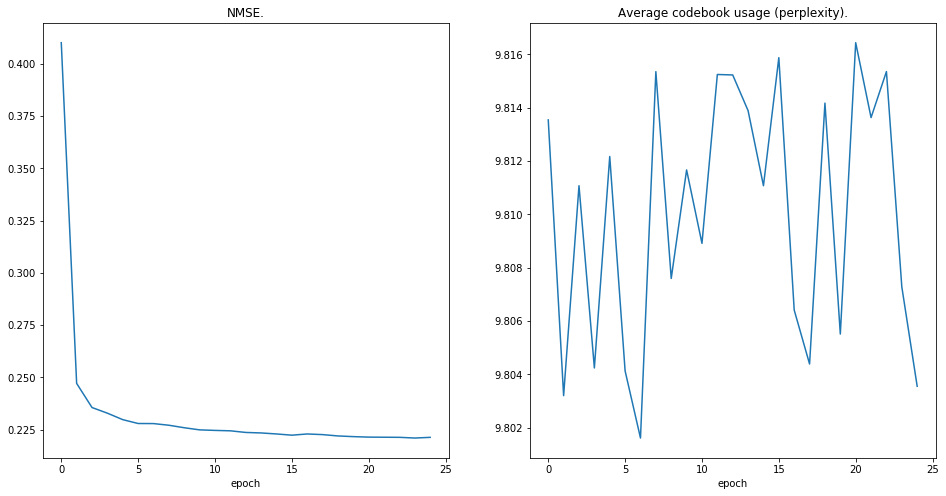

In [25]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_error)
ax.set_title('NMSE.')
ax.set_xlabel('epoch')

ax = f.add_subplot(1,2,2)
ax.plot(train_perplexity)
ax.set_title('Average codebook usage (perplexity).')
ax.set_xlabel('epoch')

In [26]:
torch.save(model_S_VQ_VAE.encoder, 'S_VQ_VAE_encode.pth')
torch.save(model_S_VQ_VAE.fc1, 'S_VQ_VAE_fc1.pth')
torch.save(model_S_VQ_VAE._vq._embedding, 'S_VQ_VAE_embedding.pth')
torch.save(model_S_VQ_VAE.decoder, 'S_VQ_VAE_decode.pth')

In [27]:
model_S_VQ_VAE.eval()
testLossList = []
for step, data in enumerate(testDataLoader):
    inputData, label = data
    inputData = inputData.to(device)
    label = label.to(device)
    vq_loss, data_recon, _, _, _= model_S_VQ_VAE(inputData, label)
    recon_error = criterion(data_recon, inputData)
    loss = recon_error + vq_loss
    testLossList.append(recon_error.item())
print('Test loss: %.4f' % np.mean(testLossList))

Test loss: 0.2192


### Classification

In [28]:
def S_VQ_VAE_encode(encoder, fc1, embedding, inputs):
    # Encode
    inputs = encoder(inputs)
    inputs = inputs.view(-1, 8*8*50)
    inputs = fc1(inputs)
    num_embeddings = embedding.weight.shape[0]
    
    # Calculate distances
    distances = (torch.sum(inputs**2, dim=1, keepdim=True) 
                + torch.sum(embedding.weight**2, dim=1)
                - 2 * torch.matmul(inputs, embedding.weight.t()))
            
    # Encoding
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.shape[0], num_embeddings)
    encodings.scatter_(1, encoding_indices, 1)
    
    return encodings

In [29]:
tempLoader = Tdata.DataLoader(dataset = trainDataset)
M = len(tempLoader.dataset)
print(M)
count = 0
for data, label in tempLoader:
    encodings = S_VQ_VAE_encode(model_S_VQ_VAE.encoder, model_S_VQ_VAE.fc1, model_S_VQ_VAE._vq._embedding, data)
    ec = int(torch.argmax(encodings).numpy())
    if ec == label:
        count += 1
print("MINST prediction training accuracy: " + str(round(count / M,3)))

60000
MINST prediction training accuracy: 0.829


In [30]:
M = len(testDataLoader.dataset)
print(M)
count = 0
for data, label in testDataLoader:
    encodings = S_VQ_VAE_encode(model_S_VQ_VAE.encoder, model_S_VQ_VAE.fc1, model_S_VQ_VAE._vq._embedding, data)
    ec = int(torch.argmax(encodings).numpy())
    if ec == label:
        count += 1
print("MINST prediction test accuracy: " + str(round(count / M,3)))

10000
MINST prediction test accuracy: 0.837


## S-VQ-VAE embedding frequency

In [31]:
def S_VQ_VAE_encode(encoder, fc1, embedding, inputs):
    # Encode
    inputs = encoder(inputs)
    inputs = inputs.view(-1, 8*8*50)
    inputs = fc1(inputs)
    num_embeddings = embedding.weight.shape[0]
    
    # Calculate distances
    distances = (torch.sum(inputs**2, dim=1, keepdim=True) 
                + torch.sum(embedding.weight**2, dim=1)
                - 2 * torch.matmul(inputs, embedding.weight.t()))
            
    # Encoding
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.shape[0], num_embeddings)
    encodings.scatter_(1, encoding_indices, 1)
    
    return encodings

In [32]:
S_VQ_VAE_encoder = torch.load("S_VQ_VAE_encode.pth")
S_VQ_VAE_fc1 = torch.load("S_VQ_VAE_fc1.pth")
S_VQ_VAE_embedding = torch.load("S_VQ_VAE_embedding.pth")
S_VQ_VAE_decoder = torch.load("S_VQ_VAE_decode.pth")

Target embedding index: 9
10
[(9, 4546), (4, 539), (8, 186), (1, 179), (7, 164), (0, 140), (3, 97), (5, 75), (2, 16), (6, 7)]


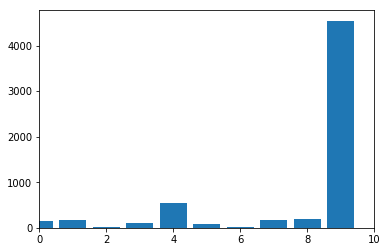

In [35]:
target = 9
print("Target embedding index: " + str(target))
tempIndex = 0
targetEncoding = {}
encodingTarget = {}
encodingNum = {}
encodingList = []
tempLoader = Tdata.DataLoader(dataset = trainDataset)
for data in tempLoader:
    tempIndex += 1
    inputData, label = data
    if label == target:
        encodings = S_VQ_VAE_encode(S_VQ_VAE_encoder, S_VQ_VAE_fc1, S_VQ_VAE_embedding, inputData)
        ec = int(torch.argmax(encodings).numpy())
        targetEncoding[target] = ec
        encodingTarget.setdefault(ec, [])
        encodingTarget[ec].append(target)
        c = encodingNum.setdefault(ec, 0)
        encodingNum[ec] = c + 1
        encodingList.append(ec)
print(len(encodingTarget))
print(sorted(encodingNum.items(), key = operator.itemgetter(1), reverse = True)[:20])
locList = []
heightList = []
for e in sorted(encodingNum.keys()):
    locList.append(e)
    heightList.append(encodingNum[e])
plt.xlim((0,10))
plt.bar(locList, heightList)
#plt.show()
plt.savefig("classification" + str(target) + ".png", dpi=350)

## Embeddings pairwise distance heatmap

In [36]:
embedding = S_VQ_VAE_embedding.weight.data.numpy()
print(embedding.shape)

(10, 3200)


(10, 10)


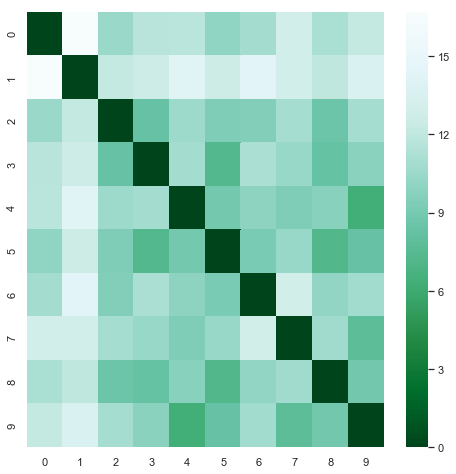

In [38]:
pairwiseDistance = pairwise_distances(embedding)
print(pairwiseDistance.shape)
sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(pairwiseDistance, cmap="BuGn_r")
plt.savefig("heatmap_MINST.png", dpi=350)

In [39]:
np.savetxt("embedding_MNIST.csv", embedding, delimiter = ',')

## S-VQ-VAE embedding code decoded images

In [40]:
def S_VQ_VAE_decode(embedding, decoder, code_index):
    num_embeddings = embedding.weight.shape[0]
            
    # Encoding
    encoding_indices = torch.tensor([[code_index]])
    #print(code_index, encoding_indices)
    encodings = torch.zeros(encoding_indices.shape[0], num_embeddings)
    encodings.scatter_(1, encoding_indices, 1)
    
    # Quantize
    quantized = torch.matmul(encodings, embedding.weight)
    quantized = quantized.view(-1,50,8,8)
    
    # Decode
    x_recon = decoder(quantized)
    
    return x_recon

In [41]:
S_VQ_VAE_encoder = torch.load("S_VQ_VAE_encode.pth")
S_VQ_VAE_fc1 = torch.load("S_VQ_VAE_fc1.pth")
S_VQ_VAE_embedding = torch.load("S_VQ_VAE_embedding.pth")
S_VQ_VAE_decoder = torch.load("S_VQ_VAE_decode.pth")

0
1
2
3
4
5
6
7
8
9


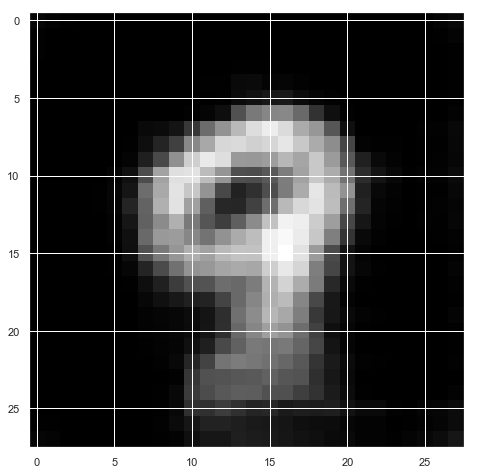

In [43]:
for i in range(10):
    print(i)
    recon = S_VQ_VAE_decode(S_VQ_VAE_embedding, S_VQ_VAE_decoder, i)
    plt.imshow(recon.data.numpy()[0][0], cmap='gray')
    plt.savefig("recon" + str(i) + ".png", dpi=350)